# Deep Q-learning (Debug Notebook)
### 2022/05/13, AJ Zerouali

My DQN agent isn't working. Seems like there's a data type issue occuring in Keras.
Precisely, this is happening when calling the learn() function, which calls upon keras.models.Sequential.train_on_batch

**Note - 18:14** This was a stupid typo. I didn't use the correct arguments for train_on_batch()
**Note - 18:46** I've been waiting for about 30min now for the execution of the "main". I think it is stuck in an infinite loop.
**Note - 18:57** Launched another training session on my machine at about 18:56. N_steps = 100, n_games = 20, mem_size = 10000. This took about 9 minutes. 

In [7]:
help(keras.models.Sequential.train_on_batch)

Help on function train_on_batch in module tensorflow.python.keras.engine.training:

train_on_batch(self, x, y=None, sample_weight=None, class_weight=None, reset_metrics=True, return_dict=False)
    Runs a single gradient update on a single batch of data.
    
    Args:
        x: Input data. It could be:
          - A Numpy array (or array-like), or a list of arrays
              (in case the model has multiple inputs).
          - A TensorFlow tensor, or a list of tensors
              (in case the model has multiple inputs).
          - A dict mapping input names to the corresponding array/tensors,
              if the model has named inputs.
        y: Target data. Like the input data `x`, it could be either Numpy
          array(s) or TensorFlow tensor(s). It should be consistent with `x`
          (you cannot have Numpy inputs and tensor targets, or inversely).
        sample_weight: Optional array of the same length as x, containing
          weights to apply to the model's loss 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Fundamental imports

What we're importing and why. Specific references to sections.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import gym

In [2]:
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
import tensorflow as tf
from tensorflow import keras


C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:18: DeprecationWarning: Call to deprecated create function FileDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  DESCRIPTOR = _descriptor.FileDescriptor(
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:36: DeprecationWarning: Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  _descriptor.FieldDescriptor(
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:29: DeprecationWarning: Call to deprecated create function Descriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  _TENSORSHAPEPROTO_

### a) Replay buffer

**To do:**
* Describe the replay buffer attributes and 2 methods.
* Give your reference: https://github.com/philtabor/Youtube-Code-Repository/blob/master/ReinforcementLearning/DeepQLearning/simple_dqn_tf2.py (has corresp. YT video).
* Compare the various design patterns encounetered (Tabor, Ravichandiran, Lapan)

In [4]:
class Replay_Buffer():
    """
        Replay Buffer class for DQN Agent.
        CONSTRUCTOR INPUT: max_size, input_dims, discrete_actions
        Attributes: 
            mem_size: Maximal size of memory (no. of (s,a,s',r) transitions); 
            mem_cntr: No. of transitions added.
            Self explanatory (np.arrays):
            memory_states, memory_actions, memory_next_states, memory_rewards, memory_terminal
            
        Methods:
            store_transitions
            sample_buffer
            
    """
    def __init__(self, max_size, input_dims, discrete_actions=True):
        """
            
        """
        
        # Memory size and counter
        self.mem_size = max_size
        self.mem_cntr = 0
        
        # Discrete actions boolean
        self.discrete_actions = discrete_actions
                
        # Transition arrays for (s,a,s',r)
        self.memory_states = np.zeros((self.mem_size, *input_dims), dtype = np.float32)
        self.memory_actions = np.zeros(self.mem_size, \
                            dtype = np.int8 if self.discrete_actions else np.float32 )
        self.memory_next_states = np.zeros((self.mem_size, *input_dims), dtype = np.float32)
        self.memory_rewards = np.zeros(self.mem_size, dtype = np.float32)
        # If memory_next_states[t] is TERMINAL, will set memory_terminal[t]= 1, and 0 otherwise.
        # Note: Different from Tabor's implementation.
        self.memory_terminal = np.zeros(self.mem_size, dtype = np.int8)
        
    def store_transition(self, state, action, new_state, reward, done):
        """
         Method for storing transitions (s, a, s', r) in the Replay_Buffer.
         INPUT: state, action, new_state, reward = (s, a, s', r)
                done: Boolean for s' terminal
         NOTE: Using tricks from P. Tabor's implementation
        """
        # Current transition index, over-write from first position when memory is full
        ind = self.mem_cntr % self.mem_size
        
        # Add new transition
        self.memory_states[ind] = state
        self.memory_actions[ind] = action
        self.memory_next_states[ind] = new_state
        self.memory_rewards[ind] = reward
        self.memory_terminal[ind] = int(done) # P. Tabor uses (1-int(done)) here
                                                # WARNING: Might be multiplying by this number somewhere
        
        # Update counter
        self.mem_cntr += 1
        
    def sample_buffer(self, batch_size):
        """
        Method for random sampling of a memory minibatch
        INPUT: batch_size
        OUTPUT: NumPy arrays of transitions of size specified by input.
        """
        
        # Choose random indices 
        max_mem = min(self.mem_size, self.mem_cntr)
        batch_indices = np.random.choice(max_mem, batch_size, replace=False)
        
        # Get random minibatch
        sample_state = self.memory_states[batch_indices]
        sample_action = self.memory_actions[batch_indices]
        sample_new_state = self.memory_next_states[batch_indices]
        sample_reward = self.memory_rewards[batch_indices]
        sample_terminal = self.memory_terminal[batch_indices]
        
        return sample_state, sample_action, sample_new_state, sample_reward, sample_terminal


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### b) DQN Agent 

**Important:** I've removed the learn() method from the agent class, for now it's a standalone function in the cell after next.


In [5]:
class DQN_Agent():
    
    # Constructor
                # Environment dimensions and action space params
    def __init__(self, input_dims, discrete_actions, n_actions,  \
                 # RL hyperparameters
                 learn_rate, gamma, epsilon, batch_size, mem_size = 1000000, \
                 # Decrement and lower bound for eps-greedy
                 epsilon_dec = 1e-3, epsilon_min =0.01, \
                 # Filename model for saving
                 dqn_fname = 'dqn_model.h5'):                                             
        """
            INPUT: learn_rate, gamma, epsilon, batch_size, mem_size: Usual deep RL hyperparam
                   input_dims: Shape of states as arrays
                   n_actions: Size of the environment action space. See notes.
                   epsilon_dec, epsilon_min: Decrement of epsilon for policy, end value of epsilon.
            NOTES: 1) For a finite action space set n_actions = env.unwrapped.action_space.n as input.
                      (i.e. size of the finite action space).
                      For continuous action space take dimensionality and bounds of the "Box" object:
                      n_actions = (env.action_space.high, env.action_space.low, env.action_space.shape).
                   2) The agent uses an epsilon-greedy policy for training, with epsilon decreasing by
                      epsion_dec at each step and down to epsilon_min.
                      (Tabor starts with epsilon = 1.0)
            
        """
        # Build agent's action space
        self.discrete_actions = discrete_actions
        if self.discrete_actions:
            self.action_space = [i for i in range(n_actions)]
        else:
            self.action_space = n_actions
            
        # State space dimensionality
        self.input_dims = input_dims
        
        # Deep RL hyperparameters
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_dec = epsilon_dec
        self.batch_size = batch_size
        self.learn_rate = learn_rate
        
        # Init. DQN (build model with method below)
        self.q_network = "EMPTY"
        self.dqn_fname =  dqn_fname
        
        # Replay buffer. Signature: Replay_Buffer(max_size, input_dims, discrete_actions)
        self.mem_size = mem_size
        self.memory_buffer = Replay_Buffer(self.mem_size, self.input_dims, self.discrete_actions)
        
    # END DEF __init__()
    
    #############################
    ## Environment interaction ##
    #############################
    
    # Choose action following epsilon-greedy policy
    # NOTE: Implemented for discrete action space ONLY
    def choose_action(self, observation):
        """
            Method choosing action in input state following epsilon-greedy policy.
            INPUT: observation (current state)
            OUTPUT: action
        """
        if np.random.uniform(0,1) < self.epsilon:
            action = np.random.choice(self.action_space) # MODIFY FOR CONTINUOUS ACTIONS
        else:
            state = np.array([observation])
            actions = self.q_network.predict(state)
            action = np.argmax(actions)
        
        return action
    # END DEF choose_action()
    
    # Sample transition storage
    def store_transition(self, state, action, new_state, reward, done):
        """
            Method to store a new (s, a, s', r, s'-terminal) transition.
            Calls method of same name from Replay_Buffer class.
        """
        self.memory_buffer.store_transition(state, action, new_state, reward, done)
    
    # END DEF store_transitions()
    
    ##########################
    ## Q-network management ##
    ##########################
    
    # Build Q-network
    def build_DQN(self, fc1_dims=256, fc2_dims=256):
        """
            Builds the DQN. 
            Will use a simple architecture here: 2 fully connected layers; each entry having 256 neurons.
            The loss function is the mean-squared error, the optimizer is Adam.
            Will return an error if attribute q_network is not "EMPTY".
            NOTE: - I will only write this function for the discrete action space for now.
                  - Will have to revise for continuous actions.
                  - I see why Tabor implemented it outside the class.
        """
        if self.q_network != "EMPTY":
            print("ERROR: Attribute q_network is non-empty.")
            self.q_network.get_config()
            return False
        else:
            # Build deep Q-network
            # Import Keras from tf in advance 
            dqn = keras.models.Sequential()
            dqn.add(keras.layers.Dense(units = fc1_dims, activation = "relu"))
            dqn.add(keras.layers.Dense(units = fc2_dims, activation = "relu"))
            dqn.add(keras.layers.Dense(units = len(self.action_space))) # MODIFY FOR CONT. ACTIONS
            dqn.compile(optimizer = keras.optimizers.Adam(learning_rate = self.learn_rate), \
                        loss = "mse")                    
            self.q_network = dqn
            return True
    # END DEF Build_DQN()
    
    # Train q_network with 
    def train_dqn(self, N_steps=0, ep_i=0, notify_end_train=False):
        """
            Method to train the agent's neural net, implements (deep) Q-learning with 1 target network.
            Will check if the memory buffer has at least self.batch_size sample transitions before
            performing training, will do nothing and return False otherwise.
            Can optionally notify when exiting train_on_batch() at every 10 steps of an episode.
            
            ARGUMENTS: - N_steps: Current step -1.
                       - ep_i: Current episode -1
                       - notify_end_train: Boolean for notifications
            
            NOTE: Should write detailed notes about this part.
                  Implemented for DISCRETE ACTIONS ONLY. To be modified.
            
        """
        if self.memory_buffer.mem_cntr < self.batch_size:
            #print("ERROR: Not enough samples (memory_buffer.mem_cntr < batch_size)") # DEBUG
            return False
        else:
            
            # Get minibatch of samples
            # Signature: sample_state, sample_action, sample_new_state, sample_reward, sample_terminal
            #            = Replay_Buffer.sample_buffer(batch_size)
            states, actions, next_states, rewards, dones = self.memory_buffer.sample_buffer(self.batch_size)
            
            # Init. Q(s,a), Q(s', a'), Q*(s,a)            
            q_eval = self.q_network.predict(states)
            q_next = self.q_network.predict(next_states)
            q_target = np.copy(q_eval)
            
            # Ones vector for "dones"
            # IMPORTANT REMARK: This might cause issues, related to Replay_Buffer.store_transition(),
            #                   on line: self.memory_terminal[ind] = int(done) 
            done_ones = np.ones(shape = dones.shape, dtype=np.int8)
            
            # Iterable for minibatch
            batch_index = np.arange(self.batch_size, dtype=np.int32)
            
            # Q-learning update (CRUCIAL)
            q_target[batch_index, actions] = rewards + self.gamma*np.max(q_next, axis = 1)*(done_ones - dones)
            
            # Train network (CRUCIAL)
            self.q_network.train_on_batch(states, q_target)
            
            if ((N_steps+1)% 10)==0 and notify_end_train:
                print(f"Done training at step {N_steps+1} of episode {ep_i+1}")
            
            # Update epsilon for policy
            if self.epsilon_min < self.epsilon:
                self.epsilon -= self.epsilon_dec
            else:
                self.epsilon = self.epsilon_min
            
            return True
    
    # END DEF learn()
    
    ###################
    ## Save/Load DQN ##
    ###################
    
    # Save trained model
    def save_dqn(self):
        """
            Save q_network under dqn_fname (h5 file).
            Calls keras.models.Sequential.save()
        """
        self.q_network.save(self.dqn_fname)
    # END DEF save_dqn()
    
    # Load model
    def load_dqn(self, model_fname):
        """
            Load q_network at model_fname (h5 file).
            Calls keras.models.load_model()
        """
        self.q_network = keras.models.load_model(model_fname)
        
    # END DEF load_dqn()    
    
# END CLASS DQN_Agent

#### Debugging the learn method

On first execution it didn't work obviously

In [7]:
# DEBUG
if True:
    # N_steps and ep_i are debugging variables
    #
    def train_dqn(self, N_steps, ep_i):
        #self = agent
        """
            Method to train the DQN agent.
            Will check if the memory buffer has at least self.batch_size sample transitions before
            performing training, will do nothing and return False otherwise.
            
            NOTE: Should write detailed notes about this part.
                  Implemented for DISCRETE ACTIONS ONLY. To be modified.
            
        """
        if self.memory_buffer.mem_cntr < self.batch_size:
            #print("ERROR: Not enough samples (memory_buffer.mem_cntr < batch_size)") # DEBUG
            return False
        else:
            
            # Get minibatch of samples
            # Signature: sample_state, sample_action, sample_new_state, sample_reward, sample_terminal
            #            = Replay_Buffer.sample_buffer(batch_size)
            states, actions, next_states, rewards, dones = self.memory_buffer.sample_buffer(self.batch_size)
            
            # Init. Q(s,a), Q(s', a'), Q*(s,a)            
            q_eval = self.q_network.predict(states)
            q_next = self.q_network.predict(next_states)
            q_target = np.copy(q_eval)
            
            # Ones vector for "dones"
            # IMPORTANT REMARK: This might cause issues, related to Replay_Buffer.store_transition(),
            #                   on line: self.memory_terminal[ind] = int(done) 
            done_ones = np.ones(shape = dones.shape, dtype=np.int8)
            
            # Iterable for minibatch
            batch_index = np.arange(self.batch_size, dtype=np.int32)
            
            # Q-learning update (CRUCIAL)
            q_target[batch_index, actions] = rewards + self.gamma*np.max(q_next, axis = 1)*(done_ones - dones)
            
            # Train network (CRUCIAL)
            self.q_network.train_on_batch(states, q_target)
            # DEBUG: Let me know wtf is going on at each 10 steps ...
            if ((N_steps+1)% 10)==0:
                print(f"Done training at step {N_steps+1} of episode {ep_i+1}")
            
            # Update epsilon for policy
            if self.epsilon_min < self.epsilon:
                self.epsilon -= self.epsilon_dec
            else:
                self.epsilon = self.epsilon_min
            
            return True
    
    # END DEF learn()

### c) The main

Should start with a small number of games, n_games = 20
Should start with a small memory, say mem_size = 1000
Is there any way to make keras give feedback on the training?

In [ ]:
import matplotlib.animation as animation

Done training at step 70 of episode 1
Done training at step 80 of episode 1
Done training at step 90 of episode 1
Done training at step 100 of episode 1
Done training at step 10 of episode 2
Done training at step 20 of episode 2
Done training at step 30 of episode 2
Done training at step 40 of episode 2
Done training at step 50 of episode 2
Done training at step 60 of episode 2
Done training at step 70 of episode 2
Done training at step 80 of episode 2
Done training at step 10 of episode 3
Done training at step 20 of episode 3
Done training at step 30 of episode 3
Done training at step 40 of episode 3
Done training at step 50 of episode 3
Done training at step 60 of episode 3
Done training at step 70 of episode 3
Done training at step 80 of episode 3
Done training at step 90 of episode 3
Done training at step 100 of episode 3
Done training at step 110 of episode 3
Done training at step 120 of episode 3
Done training at step 10 of episode 4
Done training at step 20 of episode 4
Done tra

Done training at step 80 of episode 14
Done training at step 90 of episode 14
Done training at step 100 of episode 14
Done training at step 110 of episode 14
Done training at step 120 of episode 14
Done training at step 130 of episode 14
Done training at step 140 of episode 14
Done training at step 150 of episode 14
Done training at step 160 of episode 14
Done training at step 170 of episode 14
Done training at step 180 of episode 14
Done training at step 190 of episode 14
Done training at step 200 of episode 14
Done training at step 10 of episode 15
Done training at step 20 of episode 15
Done training at step 30 of episode 15
Done training at step 40 of episode 15
Done training at step 50 of episode 15
Done training at step 60 of episode 15
Done training at step 70 of episode 15
Done training at step 80 of episode 15
Done training at step 90 of episode 15
Done training at step 100 of episode 15
Done training at step 110 of episode 15
Done training at step 120 of episode 15
Done traini

Done training at step 160 of episode 24
Done training at step 170 of episode 24
Done training at step 180 of episode 24
Done training at step 190 of episode 24
Done training at step 200 of episode 24
Done training at step 10 of episode 25
Done training at step 20 of episode 25
Done training at step 30 of episode 25
Done training at step 40 of episode 25
Done training at step 50 of episode 25
Done training at step 60 of episode 25
Done training at step 70 of episode 25
Done training at step 80 of episode 25
Done training at step 90 of episode 25
Done training at step 100 of episode 25
Done training at step 110 of episode 25
Done training at step 120 of episode 25
Done training at step 130 of episode 25
Done training at step 140 of episode 25
Done training at step 150 of episode 25
Done training at step 160 of episode 25
Done training at step 170 of episode 25
Done training at step 180 of episode 25
Done training at step 190 of episode 25
Done training at step 200 of episode 25
Done trai

Done training at step 40 of episode 36
Done training at step 50 of episode 36
Done training at step 60 of episode 36
Done training at step 70 of episode 36
Done training at step 80 of episode 36
Done training at step 90 of episode 36
Done training at step 100 of episode 36
Done training at step 10 of episode 37
Done training at step 20 of episode 37
Done training at step 30 of episode 37
Done training at step 40 of episode 37
Done training at step 50 of episode 37
Done training at step 60 of episode 37
Done training at step 70 of episode 37
Done training at step 80 of episode 37
Done training at step 90 of episode 37
Done training at step 100 of episode 37
Done training at step 110 of episode 37
Done training at step 120 of episode 37
Done training at step 130 of episode 37
Done training at step 140 of episode 37
Done training at step 150 of episode 37
Done training at step 160 of episode 37
Done training at step 170 of episode 37
Done training at step 180 of episode 37
Done training a

Done training at step 20 of episode 47
Done training at step 30 of episode 47
Done training at step 40 of episode 47
Done training at step 50 of episode 47
Done training at step 60 of episode 47
Done training at step 70 of episode 47
Done training at step 80 of episode 47
Done training at step 90 of episode 47
Done training at step 100 of episode 47
Done training at step 110 of episode 47
Done training at step 120 of episode 47
Done training at step 130 of episode 47
Done training at step 140 of episode 47
Done training at step 150 of episode 47
Done training at step 160 of episode 47
Done training at step 170 of episode 47
Done training at step 180 of episode 47
Done training at step 190 of episode 47
Done training at step 200 of episode 47
Done training at step 10 of episode 48
Done training at step 20 of episode 48
Done training at step 30 of episode 48
Done training at step 40 of episode 48
Done training at step 50 of episode 48
Done training at step 60 of episode 48
Done training 

MovieWriter ffmpeg unavailable; using Pillow instead.


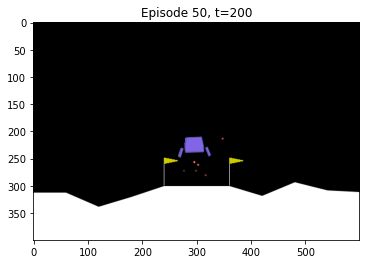

In [8]:
# Disable eager execution (NOTES)
tf.compat.v1.disable_eager_execution

# Create environment
env = gym.make('LunarLander-v2')

# Init. learn_rate and max no. of episodes
learn_rate = 0.001
#n_games = 500
n_games = 50

# Create agent
"""
class DQN_Agent():

    
    # Constructor
                # Environment dimensions and action space params
    def __init__(self, input_dims, discrete_actions, n_actions,  \
                 # RL hyperparameters
                 learn_rate, gamma, epsilon, batch_size, mem_size = 1000000, \
                 # Decrement and lower bound for eps-greedy
                 epsion_dec = 1e-3, epsilon_min =0.01, \
                 # Filename model for saving
                 dqn_fname = 'dqn_model.h5'):    
"""
agent = DQN_Agent(input_dims = env.observation_space.shape, discrete_actions= True, n_actions = env.action_space.n,\
                 learn_rate = learn_rate, gamma=0.99, epsilon=1.0, batch_size = 64, mem_size = 100000, \
                 epsilon_dec = 1e-3, epsilon_min =0.01, dqn_fname = 'dqn_attempt_0.00.h5')

# Init. score and episode (epsilon) histories
scores_hist = []
eps_hist = []

# Build the DQN (Forgot this on 1st exec...)
agent.build_DQN(256, 256)

# Visualize: gif filename
rec_gif_fname = "LunarLander_test.gif"
# Init. fig. 
fig, ax = plt.subplots()
ims = []

# Loop over episodes:
for i in range(n_games):
    
    # Init. episode
    done = False
    score = 0.0
    s = env.reset()
    # DEBUG: Fix no. of max steps
    N_steps = 0
    # Add a first frame
    img= ax.imshow(env.render('rgb_array'), animated = True)
    ims.append([img])
    
    # Loop over steps in episodes
    while not done and (N_steps < 200):
        
        # Choose an action
        a = agent.choose_action(s)
        # Get reward and next state
        s_, r, done, info = env.step(a)
        # Update score
        score += r
        # Store transition
        agent.store_transition(s, a, s_, r, done)
        
        # Add frame to ims. Should modify later to keep less frames
        ax.set_title(f"Episode {i+1}, t={N_steps+1}")
        img= ax.imshow(env.render('rgb_array'), animated = True)
        ims.append([img])
        
        # Learn
        #agent.learn()
        # DEBUG: train_dqn is the debug version of DQN_Agent.learn()
        train_dqn(agent, N_steps, i)
        # Update state
        s = s_
        # DEBUG: Increment N_steps
        N_steps += 1
        
    # END while over episode steps
    
    # Update epsilon and score histories
    eps_hist.append(agent.epsilon)
    scores_hist.append(score)

# END for i over episodes

# Stop the recording
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
env.close()
ani.save(rec_gif_fname)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


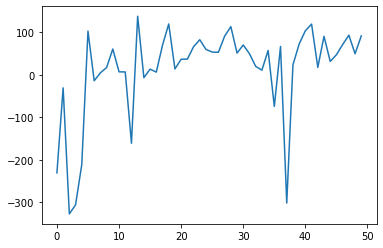

In [9]:
plt.plot(scores_hist)

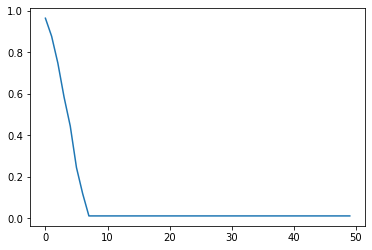

In [10]:
plt.plot(eps_hist)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


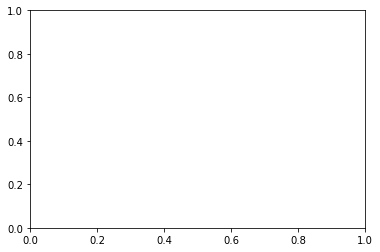

In [13]:
fig_0, ax_0 = plt.subplots()

In [14]:
ax_0.set_title(f"Episode {N_steps}")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Episode 100')

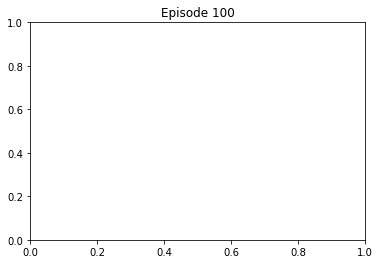

In [16]:
fig_0

In [ ]:
env.close()